In [2]:
import json
import statistics
import string
import math
from collections import defaultdict
from sklearn import linear_model
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

**loading datasets (train, valid, test)**

In [3]:
dataset = json.load(open('filter_all_t.json'))
trainSet = dataset['train']
valSet = dataset['val']
testSet = dataset['test']
len(trainSet)

87013

## Exploratory Analysis

**Determing the distribution of ratings (y) in the database**

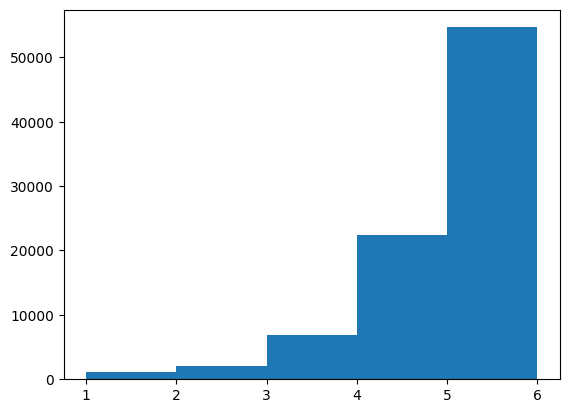

In [4]:
ratingsList = [d['rating'] for d in trainSet]
plt.hist(ratingsList, bins=range(1,7))
plt.show()

**Average rating score**

In [5]:
avgRatingScore = sum(ratingsList) / len(ratingsList)
avgRatingScore

4.465252318619057

**Average number of `history_reviews` per review**

In [6]:
histReviews = [len(d['history_reviews']) for d in trainSet]
sum(histReviews) / len(histReviews)

3.3998368059945068

**Average number of pictures per review**

In [7]:
numOfPictures = [len(d['pics']) for d in trainSet]
sum(numOfPictures) / len(numOfPictures)

1.8681001689402732

**Checking for overlapping users between the sets**

In [8]:
usersTrain = set()
restaurantsTrain = set()

for d in trainSet:
    usersTrain.add(d['user_id'])
    restaurantsTrain.add(d['business_id'])

usersValid = set()
restaurantsValid = set()

for d in valSet:
    usersValid.add(d['user_id'])
    restaurantsValid.add(d['business_id'])

# usersTest = set()
# restaurantsTest = set()

# for d in testSet:
#     usersTest.add(d['user_id'])
#     restaurantsTest.add(d['business_id'])

print("number of overlapping users between train and valid set: ", len(usersTrain.intersection(usersValid)))
print("number of overlapping restaurants between train and valid set: ", len(restaurantsTrain.intersection(restaurantsValid)))

number of overlapping users between train and valid set:  0
number of overlapping restaurants between train and valid set:  6282


## Model

**Bag-of-Words model**

In [9]:
reviewWordCount = defaultdict(int)
punctuation = set(string.punctuation)

# getting all words that are not punctuation, making sure upper/lower case doesn't matter
for d in trainSet:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  for w in r.split():
    reviewWordCount[w] += 1

print("number of unqiue review words: ", len(reviewWordCount))
reviewCounts = [(reviewWordCount[w], w) for w in reviewWordCount]
reviewCounts.sort(reverse=True)

# top 3000 most popular words from reviewCounts
reviewWords = [x[1] for x in reviewCounts[:3000]]
reviewWordId = dict(zip(reviewWords, range(len(reviewWords)))) 

number of unqiue review words:  38456


**Sentiment Analysis**

In [14]:
def feature(datum):
    vector1 = [0]*len(reviewWords)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    for w in r.split():
        if w in reviewWords:
            vector1[reviewWordId[w]] += 1

    return vector1 + [len(datum['pics'])] + [len(datum['history_reviews'])] + [1] 

X = [feature(d) for d in trainSet]
y = [d['rating'] for d in trainSet]

# Regularized regression
model = linear_model.Ridge(1.0, fit_intercept=False)
model.fit(X, y);

In [11]:
xVal, yVal = [feature(d) for d in valSet], [d['rating'] for d in valSet]
predVal = model.predict(xVal)

for i in range(len(predVal)):
    if predVal[i] > 5: predVal[i] = 5
    elif predVal[i] < 1: predVal[i] = 1
    else: predVal[i] = round(predVal[i])


MAE = mean_absolute_error(yVal, predVal)
print(MAE)

xTest, yTest = [feature(d) for d in testSet], [d['rating'] for d in testSet]
predTest = model.predict(xTest)

for i in range(len(predTest)):
    if predTest[i] > 5: predTest[i] = 5
    elif predTest[i] < 1: predTest[i] = 1
    else: predTest[i] = round(predTest[i])

MAE = mean_absolute_error(yTest, predTest)
print(MAE)

0.4778084714548803
0.4667271901951884


In [12]:
avgRatingList = [avgRatingScore for _ in yVal]
baseline = mean_absolute_error(yVal, avgRatingList)
print("baseline: ", baseline)

baseline:  0.6807998737048648


**10 most negatively weighted words and 10 most positively weighted words**

In [13]:
theta = model.coef_
wordsWeight = [(theta[i], reviewWords[i]) for i in range(len(reviewWords))]
wordsWeight.sort()
print("bottom weighted words: \n", wordsWeight[:10])
wordsWeight.sort(reverse=True)
print("top weighted words: \n", wordsWeight[:10])

bottom weighted words: 
 [(-1.2735708281612568, 'disgusting'), (-1.2115910501937235, 'worst'), (-1.0023830625127426, 'horrible'), (-0.9583125651584654, 'awful'), (-0.8620874326606889, 'edible'), (-0.8337060994392538, 'mediocre'), (-0.806961207216105, 'gross'), (-0.7694946716525985, 'tasteless'), (-0.7620199441778084, 'terrible'), (-0.7223632146993668, 'sent')]
top weighted words: 
 [(0.5248876480200869, 'ends'), (0.43378658709888424, 'vieja'), (0.3970631752421742, 'monte'), (0.3858133794622673, 'frills'), (0.37665764295895354, 'realized'), (0.3708498524411019, 'disappoint'), (0.3649667747781793, 'complaints'), (0.35737902898891843, 'behind'), (0.3504065496321682, 'exquisite'), (0.33754077403515237, 'phenomenal')]
